## Imports and Setup

In [3]:
import os
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import sys
sys.path.insert(0, "../utils/")
import data_utils
import config_utils
import pred_utils
import model_utils
import cnn_utils
import post_utils

%load_ext autoreload
%autoreload 2

## Data Configurations

In [16]:
iso_code = "SEN"
cwd = os.path.dirname(os.getcwd())

data_config_file = os.path.join(cwd, "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

# Model configuration file
#model_config_file = os.path.join(cwd, f"configs/cnn_configs/satlas-aerial_swinb_mi_01.yaml")
model_config_file = os.path.join(cwd, f"configs/cnn_configs/convnext_large_v01.yaml")
model_config = config_utils.load_config(model_config_file)
model_config["iso_codes"] = [iso_code]
classes = {1: model_config["pos_class"], 0: model_config["neg_class"]}

# Model file
exp_dir = os.path.join(
    cwd, 
    model_config["exp_dir"], 
    model_config["project"], 
    f"{iso_code}_{model_config['config_name']}"
)
model_file = os.path.join(exp_dir, f"{iso_code}_{model_config['config_name']}.pth")
model = pred_utils.load_cnn(model_config, classes, model_file)

## Load Training/Test Data

In [17]:
data = model_utils.load_data(model_config, attributes=["rurban", "iso"], verbose=False)
filepaths = data_utils.get_image_filepaths(model_config, data)
data[data['class'] == 'school'].sample(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry
5666,UNICEF-SEN-SCHOOL-00008762,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE GAWDAL 1,83bd064d-235b-3920-8bdf-ad0197d7f19d,0,0.0,school,13,rural,train,POINT (-1313621.094 1974374.111)
5070,UNICEF-SEN-SCHOOL-00007891,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE WOURO DIERY,658c40f6-91c8-3fdb-82ab-ef5697a681ef,0,0.0,school,13,rural,val,POINT (-1457896.867 2029352.135)
3358,UNICEF-SEN-SCHOOL-00005058,UNICEF,SEN,Senegal,Africa,Sub-Saharan Africa,EE GODEL,330a8b15-53da-307d-9d3b-49cc11044394,0,0.0,school,12,rural,train,POINT (-1625729.028 1786689.685)


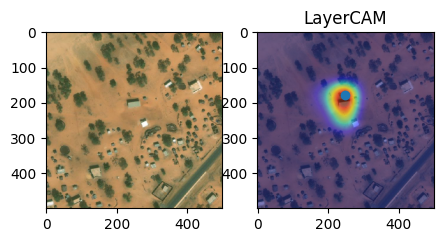

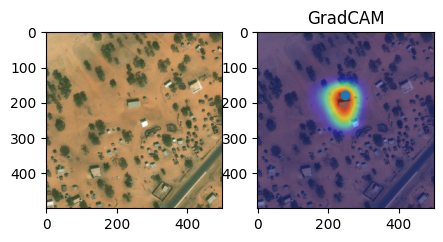

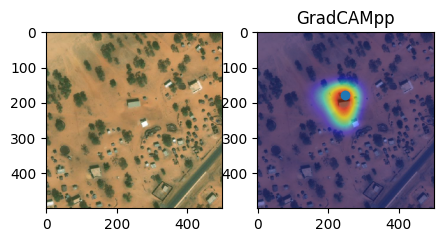

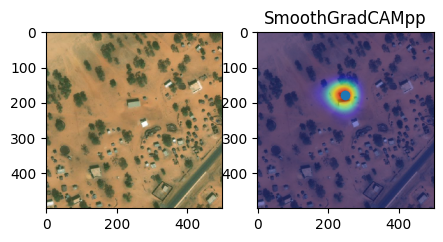

In [18]:
index = 5070
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

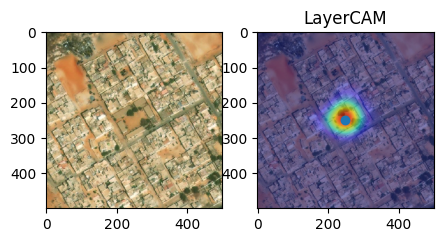

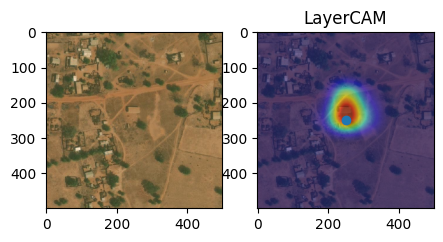

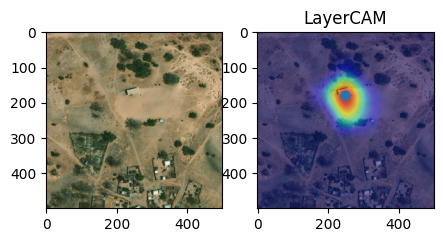

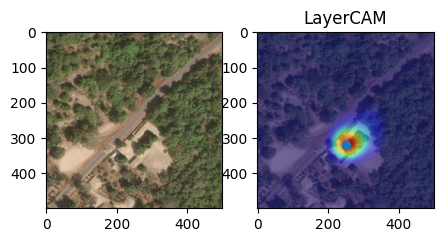

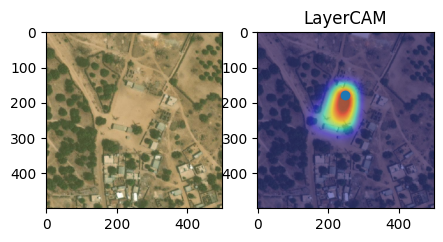

In [19]:
if model_config["type"] == "cnn":
    from torchcam.methods import LayerCAM
    model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
    cam_extractor = LayerCAM(model)
    
elif model_config["type"] == "vit":
    from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, LayerCAM
    model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
    target_layers = [model.module.model.backbone.backbone.features[-1][-2].norm1]
    cam_extractor = LayerCAM(
        model=model, 
        target_layers=target_layers, 
        reshape_transform=pred_utils.reshape_transform
    )

for index in list(data[data['class'] == 'school'].sample(5).index):
    _, point = pred_utils.generate_cam(
        model_config, filepaths[index], model, cam_extractor, title="LayerCAM"
    )

## Load Model Outputs

In [22]:
shapename = "Fatick"
name = f"{iso_code}_{shapename}"
sat_dir = os.path.join(cwd, "output", iso_code, "images", shapename)
data = post_utils.load_data(iso_code, data_config, model_config, sum_threshold=5, source="pred")
filepaths = data_utils.get_image_filepaths(model_config, data, in_dir=sat_dir)
data.sample(3)

,prob,UID,sum,group,geometry,ADM1,ADM2,ADM3,PUID
8954,0.836095,171655,6.0,12464,"POLYGON ((-1855787.612 1635499.584, -1855787.6...",Thies,Mbour,Fissel,Mbour_171655
9422,0.803239,8893,13.0,5109,"POLYGON ((-1921577.408 1664670.372, -1921577.4...",Dakar,Rufisque,Sangalkam,Rufisque_8893
1758,0.969857,103134,19.0,8170,"POLYGON ((-1866950.118 1661374.691, -1866950.1...",Thies,Thies,Tieneba,Thies_103134


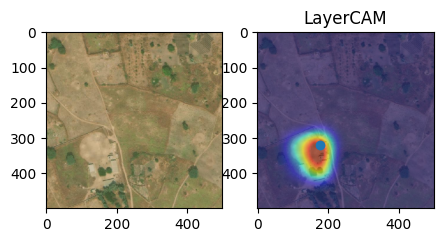

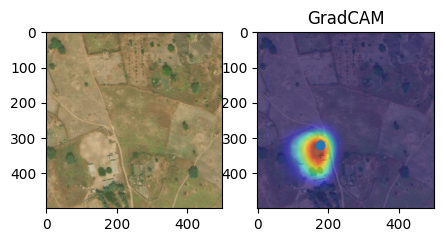

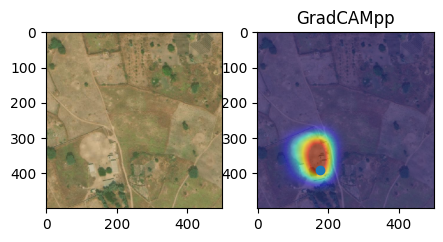

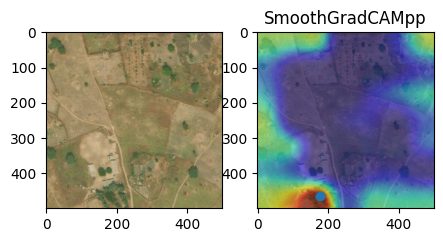

In [23]:
index = data[data.PUID == 'Fatick_29335'].index[0]
pred_utils.compare_cams(filepaths[index], model, model_config, classes, model_file)

## Visualize CAMs for Different Images

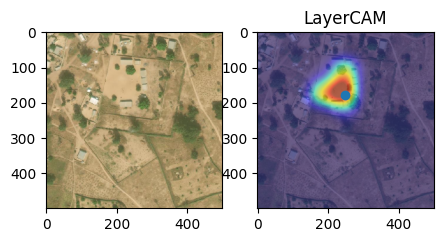

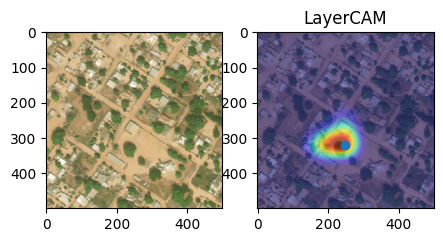

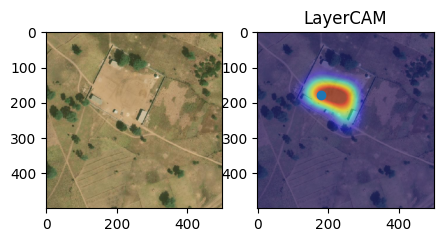

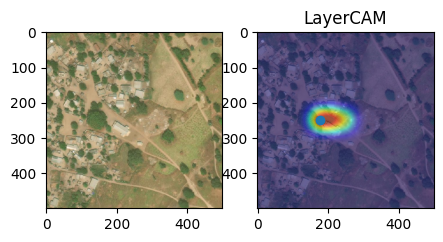

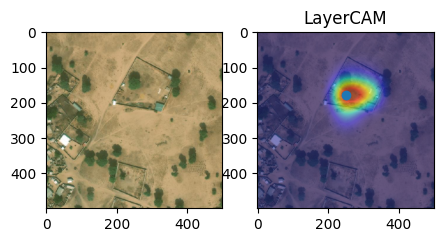

In [24]:
if model_config["type"] == "cnn":
    from torchcam.methods import LayerCAM
    model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
    cam_extractor = LayerCAM(model)
    
elif model_config["type"] == "vit":
    from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, LayerCAM
    model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
    target_layers = [model.module.model.backbone.backbone.features[-1][-2].norm1]
    cam_extractor = LayerCAM(
        model=model, 
        target_layers=target_layers, 
        reshape_transform=pred_utils.reshape_transform
    )

for index in list(data[(data["ADM2"] == shapename) & (data['prob'] > 0.73)].sample(5).index):
    _, bbox = pred_utils.generate_cam(
        model_config, filepaths[index], model, cam_extractor, title="LayerCAM"
    )

## Georeference Images

In [ ]:
sat_config_file = os.path.join(cwd, 'configs/sat_configs/sat_config_500x500_60cm.yaml')
sat_config = config_utils.load_config(sat_config_file)
geotiff_dir = data_utils._makedir(os.path.join("output", iso_code, "geotiff", shapename))
pred_utils.georeference_images(data[data["pred"] == "school"], sat_config, sat_dir, geotiff_dir)

## Generate Bounding Boxes from CAMs

In [ ]:
from torchcam.methods import LayerCAM
model = pred_utils.load_cnn(model_config, classes, model_file, verbose=False).eval()
cam_extractor = LayerCAM(model)
results = pred_utils.generate_cam_bboxes(
    data[data['pred'] == 'school'].reset_index(drop=True), 
    model_config,
    geotiff_dir, 
    model, 
    cam_extractor
)
out_dir = os.path.join(cwd, "output", iso_code, "results")
filename = f"{iso_code}_{shapename}_{model_config['model']}_cam.gpkg"
out_file = os.path.join(out_dir, filename)
results.to_file(out_file, driver="GPKG")